<a href="https://colab.research.google.com/github/jameswilsenach/ClustRepVAE/blob/main/ClustRepVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ClustRepVAE

ClustRep is a method for producing representations of clusters of high-dimensional data using a $\beta$-VAE as a method for constructing disentangled latent gaussian representations of these clusters. The method uses moment matching and/or results on the Wasserstein barycentres to find the gaussian distribution that best captures sampling from the mixture model of members' latent distribution.

The demonstration below uses the well known MNIST, handwritten digits dataset.

In [1]:
import imageio
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.utils.data import Subset
to_pil_image = transforms.ToPILImage()
def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('./output/generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"./output/output{epoch}.jpg")
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./output/loss.jpg')
    plt.show()

In [2]:
!pwd
!mkdir ./input
!mkdir ./output

/content


## $\beta$-VAE Loss

The representational model uses the $\beta$-VAE loss which is a weighted sum of standard reconstruction loss and the KL-divergence. The weight $\beta$ can be altered as a hyperpapameter (higher
$\beta$ increases disentanglement).

In [3]:
from tqdm import tqdm
import torch
def final_loss(bce_loss, mu, logvar,beta=5):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD

## Training and Validation

In [4]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter
    return train_loss

In [5]:
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()

            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size,
            stride=2, padding=0
        )

        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)

        # decoder
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )

        for m in self.children():
            if isinstance(m, (nn.Linear,nn.ConvTranspose2d,nn.Conv2d)):
              nn.init.xavier_normal_(m.weight)
              m.bias.data.fill_(0.0)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def forward(self, x):
        # encoding

        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))

        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)

        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)

        z = z.view(-1, 64, 1, 1)

        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))

        return reconstruction, mu, log_var

    def forwardZ(self,mu,logvar):
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)

        z = z.view(-1, 64, 1, 1)

        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

100%|██████████| 9912422/9912422 [00:00<00:00, 91517192.05it/s]


Extracting ./input/MNIST/raw/train-images-idx3-ubyte.gz to ./input/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 52034232.74it/s]

Extracting ./input/MNIST/raw/train-labels-idx1-ubyte.gz to ./input/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25966401.58it/s]


Extracting ./input/MNIST/raw/t10k-images-idx3-ubyte.gz to ./input/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17938351.01it/s]


Extracting ./input/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./input/MNIST/raw

Epoch 1 of 10


938it [00:23, 39.52it/s]                         
157it [00:02, 68.52it/s]                         


Train Loss: 16710.2167
Val Loss: 13855.4459
Epoch 2 of 10


938it [00:16, 55.53it/s]                         
157it [00:02, 77.62it/s]                         


Train Loss: 13674.6000
Val Loss: 13437.7260
Epoch 3 of 10


938it [00:17, 53.92it/s]                         
157it [00:02, 64.33it/s]                         


Train Loss: 13417.5377
Val Loss: 13340.6245
Epoch 4 of 10


938it [00:16, 56.08it/s]                         
157it [00:02, 75.77it/s]                         


Train Loss: 13306.0342
Val Loss: 13176.0746
Epoch 5 of 10


938it [00:16, 56.17it/s]                         
157it [00:02, 74.48it/s]                         


Train Loss: 13227.1522
Val Loss: 13096.6288
Epoch 6 of 10


938it [00:16, 57.19it/s]                         
157it [00:02, 76.20it/s]                         


Train Loss: 13168.6782
Val Loss: 13072.9006
Epoch 7 of 10


938it [00:16, 55.72it/s]                         
157it [00:02, 77.63it/s]                         


Train Loss: 13123.4586
Val Loss: 13048.7890
Epoch 8 of 10


938it [00:16, 57.83it/s]                         
157it [00:02, 74.75it/s]                         


Train Loss: 13092.9633
Val Loss: 13003.3592
Epoch 9 of 10


938it [00:16, 55.72it/s]                         
157it [00:02, 75.51it/s]                         


Train Loss: 13062.8056
Val Loss: 12983.5511
Epoch 10 of 10


938it [00:16, 57.76it/s]                         
157it [00:02, 77.38it/s]                         


Train Loss: 13040.2444
Val Loss: 12951.2417


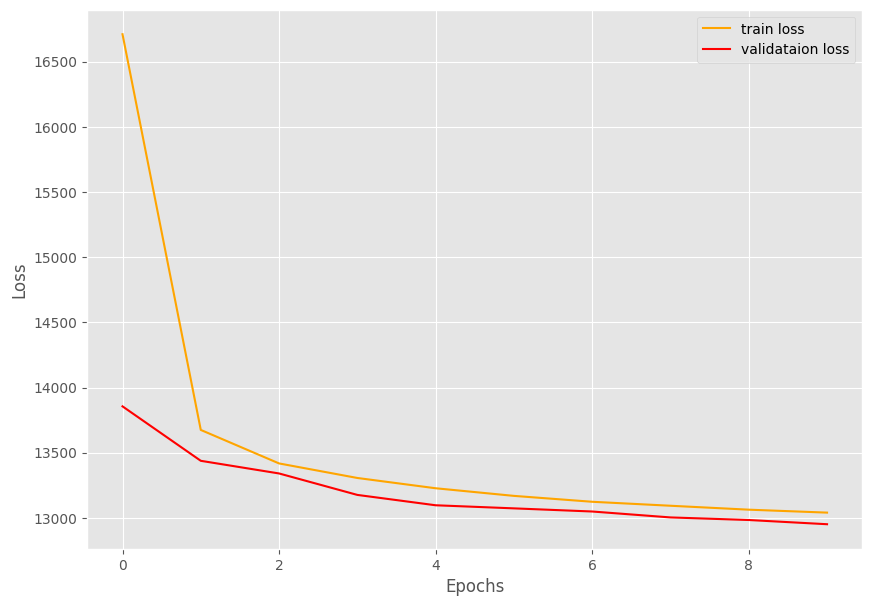

TRAINING COMPLETE


In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import matplotlib
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
matplotlib.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 10
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='./input', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='./input', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

    # save the reconstructions as a .gif file
image_to_vid(grid_images)
# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)
print('TRAINING COMPLETE')

## Latent Mean and Variance Extraction

Latent mean and variance are produced for all validation images and subsampled to produce a linkage hierarchical clustering of the images based on their latent representation as a multivariate gaussian distribution.

In [8]:
dataset = testset
dataloader = DataLoader(
    dataset, batch_size=dataset.data.numpy().shape[0], shuffle=False
)
model.eval()
for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
    data= data[0]
    data = data.to(device)
    _, mu, logvar = model(data)

100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


In [9]:
mu = mu.cpu().data.numpy()
logvar = logvar.cpu().data.numpy()

In [10]:
muvar = np.concatenate((logvar,mu),1)

In [11]:
muvar.shape

(10000, 32)

In [12]:
pwcorrmuvar = np.corrcoef(muvar)

In [13]:
divs = 10
subs = np.arange(0,len(muvar),divs)
muvarsub = muvar[subs,:]

Text(0.5, 1.0, 'hierarchical ward clustering')

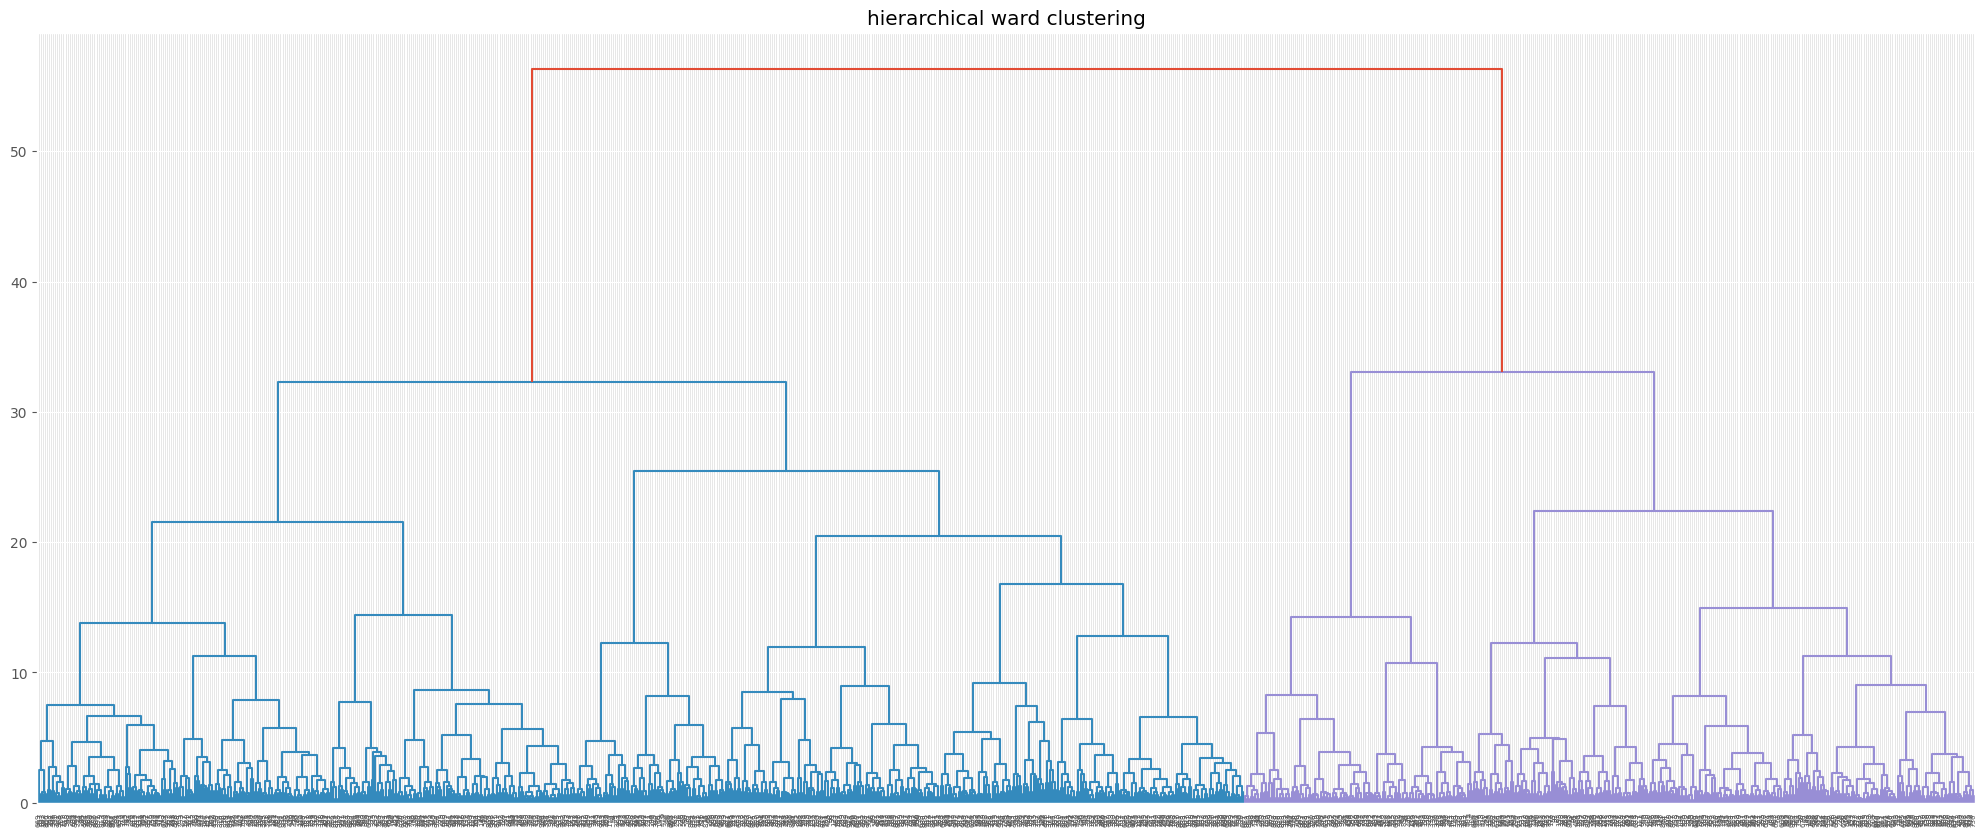

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform,pdist
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

pw = pdist(muvarsub,metric='euclidean')
Z = linkage(pw, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.title('hierarchical ward clustering')

In [15]:
clusters = fcluster(Z,10,'distance')

In [16]:
print(clusters)
print(np.sum(clusters==1))

[18  6 21  2 15  7 16 18 19  1  7  3 12  7  7 19 19 19 15 13 12 19 16  1
  3 11  5  3  1 11 20  1 21 15  1 14 11 17 10  9  9 16 20 15 10  3  4  5
 13 10  3 17  5 19  5 17 21  5  5  3  7  8  6 19 14  7 20 21  7  9 14  5
  3  4 19  6 21 11  3 13  3 17  7  1 13 13  7  5 18  3  2 19 15 17  5 17
 21  5  9  9 21 11  3 15 15  1 11 12 19 19 17 18  5 11 19  3 19 12 14  5
  5  9 10 19 13  7 15 21 15  3 19  2  5 17  5 15 15  5 19 10  7  8  7 14
 20 10  5  4  3  3 13  3 21 17 16  4  5 10 20  6  5 12  9 15 11  6 18  5
 20  2  6 18 11  5  5 17 13 18 15 12  8  3 13 15  3 17  2 10 10  9  5  2
 19  8  4 16 12  1 20  7  7 14  2  5 10 12 12 19  1 19  3  9 20 21  8  8
  7  8  3  6  8  7 17  1 16 21  1 18  3 18  3 19 14 19 11  8  7 10 12  9
  3  6 11  5 21  3  5 12 18 18  9 13  5 19  3  5  3 19  7 13 12  9  8 11
  5  5  6 12 19  2 16 16 21 11 21  5 13  8  8  5 12  3 17  8  1  1  8 19
 13 18 12  9  7  4  1 13 12  3  7 12  7  2 10  5 18 13 15 15  1  6  3  3
  8  6  6  2 19 10  9 19 11  6  5 14  5  8 12 10 17

In [17]:
testsub = Subset(dataset,subs)

In [18]:
clustset = Subset(testsub,np.arange(len(clusters))[clusters==1])

In [19]:
len(clustset)

73

In [20]:
clustloader = DataLoader(
    clustset, batch_size=len(clustset), shuffle=False
)
with torch.no_grad():
    for i, data in tqdm(enumerate(clustloader), total=int(len(clustset)/clustloader.batch_size)):
        data= data[0]
        data = data.to(device)
        _, muclust, logvarclust = model(data)

100%|██████████| 1/1 [00:00<00:00, 26.57it/s]


## Cluster Mode Matching

After training, each member of each cluster can be identified with a multivariate gaussian distribution (encoded by the latent variables). The technique uses the method of moment matching to find the multivariate gaussian distribution that best matches the cluster to the cluster mixture. This procedure assumes independence and that members of the cluster are sampled indpendently at random. Since there are no dependencies between latent dimensions (diagonal ovariance matrix), it is sufficient to consider the univariate case.

In this case each cluster member represents a gaussian random variable $X_i$ (with mean $\mu_i$ and standard deviation $\sigma_i$), which could be sampled with uniform probability $\frac{1}{n}$. The mixture model $\mathbf{X}$ has mean

$$
\textrm{E}[\mathbf{X}]=\frac{1}{n}\sum_{i=1}^{n} \mu_i
$$
and variance,
$$
\textrm{Var}[\mathbf{X}]=\frac{1}{n}\left[\sum_{i=1}^{n} \mu_i^2+\sigma_i^2\right]-\frac{1}{n^2}\left[\sum_{i=1}^{n} \mu_i\right]^2.\\[10pt]
$$


The new variable $\mathbf{\bar X}\sim N(\textrm{E}[\mathbf{X}],\textrm{Var}[\mathbf{X}])$, represents sampling from the cluster. Samples from \mathbf{\bar X} can be passed through the VAE architecture to visualise sampling from the cluster and it can be used as a proxy to represent the cluster.

In [21]:
clustmean = np.mean(muclust.cpu().data.numpy(),axis=0)

In [22]:
varcpu = np.exp(logvarclust.cpu().data.numpy())
n = len(varcpu)
clustlogvar = np.log(np.sum(varcpu+muclust.cpu().data.numpy()**2,axis=0)/n-np.sum(muclust.cpu().data.numpy(),axis=0)**2/n**2)

In [23]:
clustlogvar

array([ 4.0645143e-03, -2.4111108e-03, -1.1711423e+00,  6.1148219e-03,
       -5.6938641e-04,  2.5877822e-03,  6.4910534e-03,  4.9174326e-03,
       -6.2011725e-01, -7.6040500e-01, -2.4422402e-03, -8.4482801e-01,
        1.0427398e-02, -8.0604053e-01, -7.1173869e-03, -9.6641146e-03],
      dtype=float32)

## Cluster Wasserstein Barycentre

An alternative formulation for the cluster centres is to take use what is known about the Wasserstein barycentres of commuting covariance matrices. In this case, all latent covariance matrices are diagonal and thus commute. In Alvarez-Esteban, 2016, the authors show that the a variable following the Wasserstein barycentre distribution, $\hat{\mathbf{X}}$ has mean $\textrm{E}[\hat{\mathbf{X}}]=\textrm{E}[\mathbf{X}]$ as before, and variance
$$
\textrm{Var}[\hat{\mathbf{X}}]=\frac{1}{n^2}\left[\sum_{i=1}^{n} \sigma^{1/2}\right]^2.
$$
Again, this result generalises to the multidimensional case due to the diagonal covariance matrices of the latent variables.

In [24]:
varcpu = np.exp(logvarclust.cpu().data.numpy())
n = len(varcpu)
clustlogvar = np.log(1/n**2*np.sum(varcpu**(1/2),axis=0)**2)

In [25]:
clustlogvar

array([ 4.0008752e-03, -2.4822738e-03, -3.6254814e+00,  6.0176621e-03,
       -6.7316293e-04,  2.4317715e-03,  6.3759247e-03,  4.8670149e-03,
       -2.4325418e+00, -3.0564332e+00, -2.6047148e-03, -2.4790554e+00,
        1.0157204e-02, -2.5583391e+00, -7.2973743e-03, -9.8240338e-03],
      dtype=float32)

In [26]:
ind = 0
logvarclust.cpu().numpy()[ind,:]

array([ 1.0247964e-03,  2.3826538e-03, -3.5130978e+00,  3.8178787e-03,
       -7.7552889e-03,  4.1282829e-03,  1.4888695e-02,  4.8110289e-03,
       -2.3552809e+00, -2.9784491e+00, -7.8937169e-03, -2.4050884e+00,
        1.0689231e-02, -2.4902563e+00, -1.1918786e-02, -8.7039880e-03],
      dtype=float32)

In [27]:
clustmean

array([-0.00160943,  0.02023448,  0.5247331 ,  0.0040304 , -0.00440361,
        0.0143161 , -0.02229321,  0.00735823,  1.0477186 , -0.6418278 ,
        0.0071789 ,  0.9870592 , -0.01968043, -1.0097457 , -0.02711599,
       -0.00557469], dtype=float32)

In [28]:
muclust.cpu().numpy()[ind,:]

array([-2.6056655e-03,  1.3870494e-02,  8.1394160e-01,  9.1249682e-03,
        3.0690245e-03,  1.4142904e-02, -2.6035152e-02,  1.2683466e-02,
        1.6823031e+00, -1.1736715e-01,  1.6414948e-02,  4.6770668e-01,
       -2.9573202e-02, -1.0639527e+00, -2.0287383e-02, -1.5032589e-03],
      dtype=float32)

Text(0.5, 1.0, 'cluster densities')

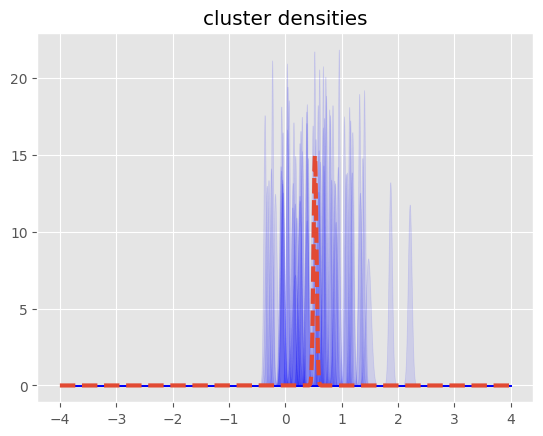

In [39]:
from scipy.stats import norm
dim = 2
x_axis = np.arange(-4, 4, 0.001)
for i in range(np.sum(clusters==1)):
  plt.fill_between(x_axis, 0, norm.pdf(x_axis,muclust.cpu().numpy()[i,dim],np.exp(logvarclust.cpu().numpy()[i,dim])), color='blue',alpha=0.1)
plt.plot(x_axis, norm.pdf(x_axis,clustmean[dim],np.exp(clustlogvar[dim])),'--',lw=3)
plt.title('cluster densities')

## Cluster Representative Sampling

We can sample plausible representative values for the cluster by sampling from the representative distribution.

In [35]:
b=10
tensmu = torch.from_numpy(clustmean).float().to(device).unsqueeze(0).repeat(b,1)
tenslogvar = torch.from_numpy(clustlogvar).float().to(device).unsqueeze(0).repeat(b,1)

print(tensmu.shape)

z = model.reparameterize(tensmu, tenslogvar)
z = model.fc2(z)

z = z.view(-1, 64, 1, 1)

# decoding
x = F.relu(model.dec1(z))
x = F.relu(model.dec2(x))
x = F.relu(model.dec3(x))
reconstruction = torch.sigmoid(model.dec4(x))

torch.Size([10, 16])


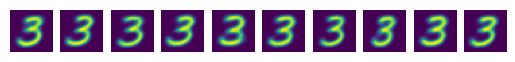

In [36]:
fig,ax=plt.subplots(ncols=b)
for i,a in enumerate(ax):
  a.imshow(np.squeeze(reconstruction.cpu().detach().numpy()[i]))
  a.axis('off')

In [37]:
from sklearn.manifold import Isomap

y = Isomap(n_components = 2,metric="euclidean").fit_transform(muvarsub)

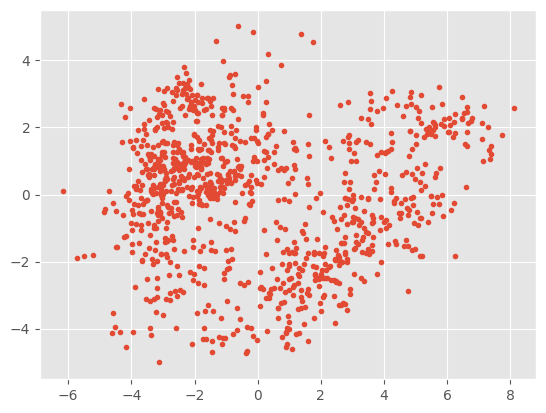

In [38]:
plt.plot(y[:,0],y[:,1],'.')

## TO DO



*   Add probablistic metric to clustering
*   Add functionality for other clustering techniques/datasets
*   Re-train with larger number of epochs



